# Data Owner (Client1) – prepare and serve Twin

This notebook loads the private + public single-cell AnnData files, builds a Twin, publishes it, and handles computation requests from Client2.

## Setup
- Optional: install deps if needed.
- Add the project src to `sys.path` and import Beaver.

In [1]:
!cd shared && ls

In [2]:
# # Clean start
!cd shared && rm -rf public client1 client2

In [3]:
# Optional: install if your env doesn't have these yet
# !uv pip install scanpy anndata matplotlib scikit-misc

In [4]:
!uv pip install scanpy anndata matplotlib scikit-misc

Audited 4 packages in 7ms


In [5]:
import sys
from pathlib import Path
import scanpy as sc
from beaver import Twin
import beaver

# Make package importable from repo
sys.path.insert(0, "../../python/src")

bv = beaver.connect("shared", user="client1")

🔄 Auto-load replies enabled for client1 (polling every 2.0s)


## Load raw/private and mock/public data

In [6]:
data_dir = Path("../../notebooks/single_cell/data")
private_path = data_dir / "sc_RNAseq_adata_downsampled_to5percent.private.h5ad"
mock_path = data_dir / "sc_RNAseq_adata_downsampled_to5percent.mock.h5ad"
sim_path = data_dir / "adata_simulated.h5ad"

In [7]:
adata_sim = sc.read(sim_path)

In [8]:
adata_sim.obs.rename(
    columns={"pct_counts_in_top_50_genes": "pct_counts_mt"},
    inplace=True,
)
adata_sim.obs.rename(columns={"group": "cell_type"}, inplace=True)

In [9]:
adata_sim.write_h5ad(mock_path)

In [10]:
adata_private = sc.read(private_path)
adata_mock = sc.read(mock_path)

In [11]:
# # A way to visualise quality metrics of the matrices
# sc.pl.violin(adata_private, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)

In [12]:
# # A way to visualise quality metrics of the matrices
# sc.pl.violin(adata_mock, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)

In [13]:
import anndata as ad
from beaver.runtime import TrustedLoader  # available via bv.type_registry()

In [14]:
@TrustedLoader.register(ad.AnnData)
def annadata_serialize_file(obj, path):
  # write to the provided path; only the path + loader code is sent
  obj.write_h5ad(path)

@TrustedLoader.register(ad.AnnData)
def annadata_deserialize_file(path):
  return ad.read_h5ad(path)

## Build Twin and share with Client2
- Private side: full dataset
- Public side: simulated/mock dataset
- Publish to registry and send to Client2's inbox

In [15]:
patient_sc = Twin(
    private=adata_private,
    public=adata_mock,
    owner="client1",
    name="patient_sc",
)

# Publish to public registry and send to Client2
bv.remote_vars["patient_sc"] = patient_sc
# send_result = bv.send(patient_sc, user="client2")
# send_result

🌍 Using PUBLIC data from Twin 'patient_sc...'
📢 Published Twin 'patient_sc' (public side available at: shared/public/client1/data/34315178baa644e68d7bc910cbfc8446.beaver)


In [16]:
# # A way to visualise quality metrics of the matrices
# sc.pl.violin(patient_sc.private, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)

In [17]:
patient_sc.can_send()

🔒 Using PRIVATE data from Twin 'patient_sc...'


(True, 'ok: Twin serializes')

## Handle computation requests from Client2
Run this cell whenever new requests arrive to execute them on the private data, review, and approve.

In [18]:
bv.wait_for_message()

📬 New message: request_make_violin_for_result
   From: client2


(BeaverEnvelope [CODE]: request_make_violin_for_result
   From: client2
   Type: ComputationRequest (__main__)
   Size: 45935116 bytes
   Created: 2025-11-25 05:11:03 UTC
   ID: 83adf818...
 
 Arguments (1):
   [0] 🌍 PUBLIC Twin: patient_sc (type: Twin[dict], owner: client1)
 
 Bound Data:
   │ 🌍 PUBLIC
   │   Parameter: patient_sc
   │   Type: dict
   │   Owner: client1
   │   📊 Mock data available for testing
 
 Signature: request_make_violin_for_result(adata)
 
 Source:
   def make_violin(adata):
       n_cells = adata.n_obs
       print("stdout", "n_cells", adata.n_obs)
       import sys
       sys.stdout.write("Another stdout line\n")
       sys.stderr.write("Another stderr line\n")
   
       # A way to visualise quality metrics of the matrices
       import matplotlib.pyplot as plt
       sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)
       fig = plt.gcf()  # get current figure
       return fig,
 ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
bv.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
request_make_violin_for_result,83adf818b84c...,client2,ComputationRequest,45935116,2025-11-25 05:11:03,


In [20]:
bv.inbox()[0]

BeaverEnvelope [CODE]: request_make_violin_for_result
  From: client2
  Type: ComputationRequest (__main__)
  Size: 45935116 bytes
  Created: 2025-11-25 05:11:03 UTC
  ID: 83adf818...

Arguments (1):
  [0] 🌍 PUBLIC Twin: patient_sc (type: Twin[dict], owner: client1)

Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

Signature: request_make_violin_for_result(adata)

Source:
  def make_violin(adata):
      n_cells = adata.n_obs
      print("stdout", "n_cells", adata.n_obs)
      import sys
      sys.stdout.write("Another stdout line\n")
      sys.stderr.write("Another stderr line\n")
  
      # A way to visualise quality metrics of the matrices
      import matplotlib.pyplot as plt
      sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], size=0, multi_panel=True)
      fig = plt.gcf()  # get current figure
      return fig

In [21]:
bv.inbox()[0].load()

✓ Loaded 'request_make_violin_for_result' into globals


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: make_violin_result
   Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: make_violin

📦 Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=099794efa09a... result=119f7adb7f8f...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
request_make_violin_for_result

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: make_violin_result
   Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: make_violin

📦 Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=099794efa09a... result=119f7adb7f8f...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [23]:
x = request_make_violin_for_result.run_mock()

🧪 Testing on mock/public data...
✓ Mock result: Figure


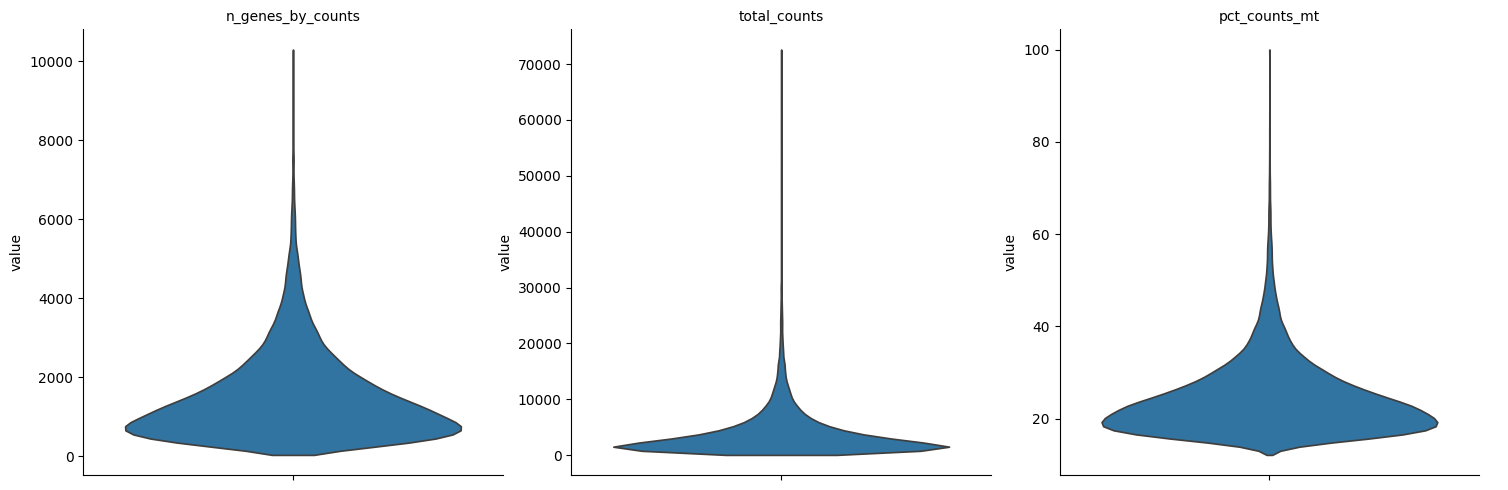

In [24]:
x.public_figures[0]

In [25]:
result = request_make_violin_for_result.run_both()

🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
✓ Mock result: Figure
🔒 Step 2/2: Executing on real/private data...
✓ Private result: Figure


In [26]:
result

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ComputationResult: make_violin_result
  Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  Twin: make_violin_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    <Figure size 1511.11x500 with 3 Axes>    ← .value uses this
  🌍 Public    <Figure size 1511.11x500 with 3 Axes>    ✓
  Live: ⚫ Disabled
  📤 Captured stdout: 41 chars
  ⚠️  Captured stderr: 20 chars
  📊 Captured figures: 2
  IDs: twin=fb55c42d... private=22a4a5ea... public=61532826...
  💡 Access: .public_stdout, .public_stderr, .public_figures

  📤 Output captured during execution:
     stdout n_cells 7876
     Another stdout line

  💡 Actions:
     .approve()           - Send private/real result back
     .approve_mock()      - Send mock result (continue iteration)
     .reject(message)     - Reject with explanation
     .data                - Access Twin to inspect/modify

In [27]:
result.public_stdout

'stdout n_cells 30000\nAnother stdout line\n'

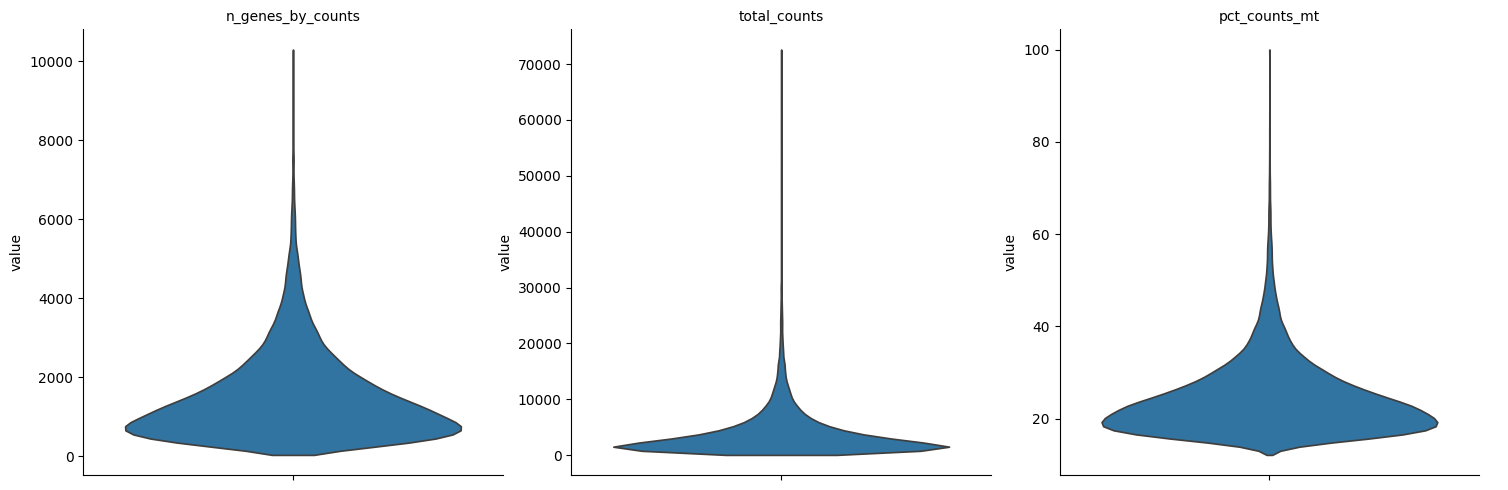

In [28]:
result.public_figures[0]

In [29]:
print(result.private_stdout)
print(result.private_stderr)

stdout n_cells 7876
Another stdout line

Another stderr line



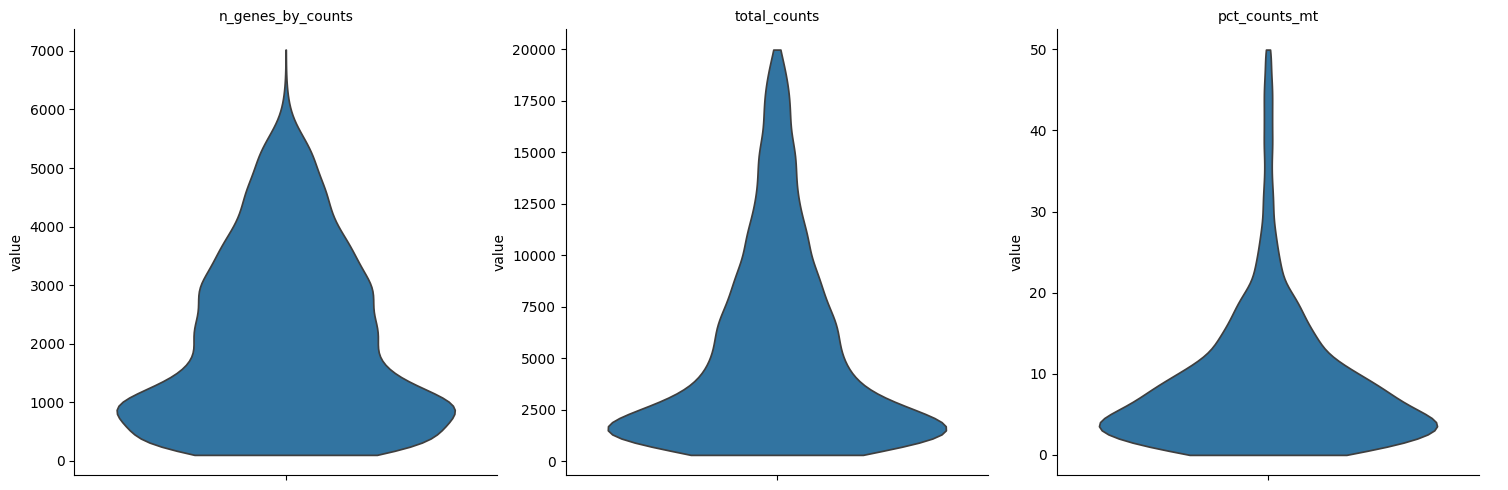

In [30]:
result.private_figures[0]

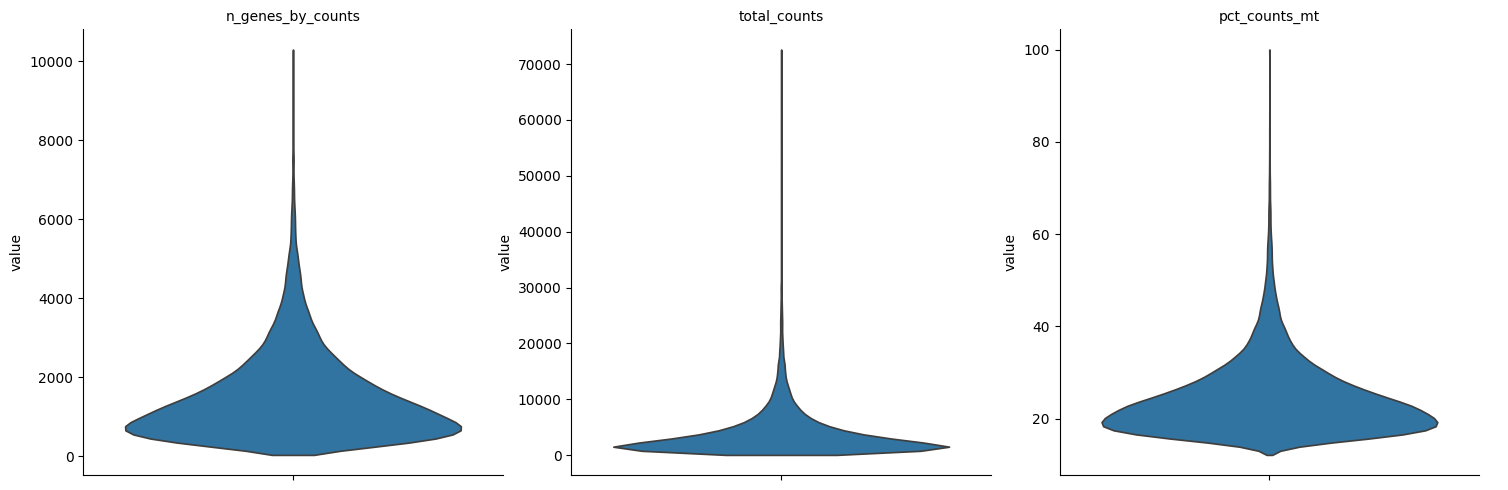

In [31]:
result.data.public

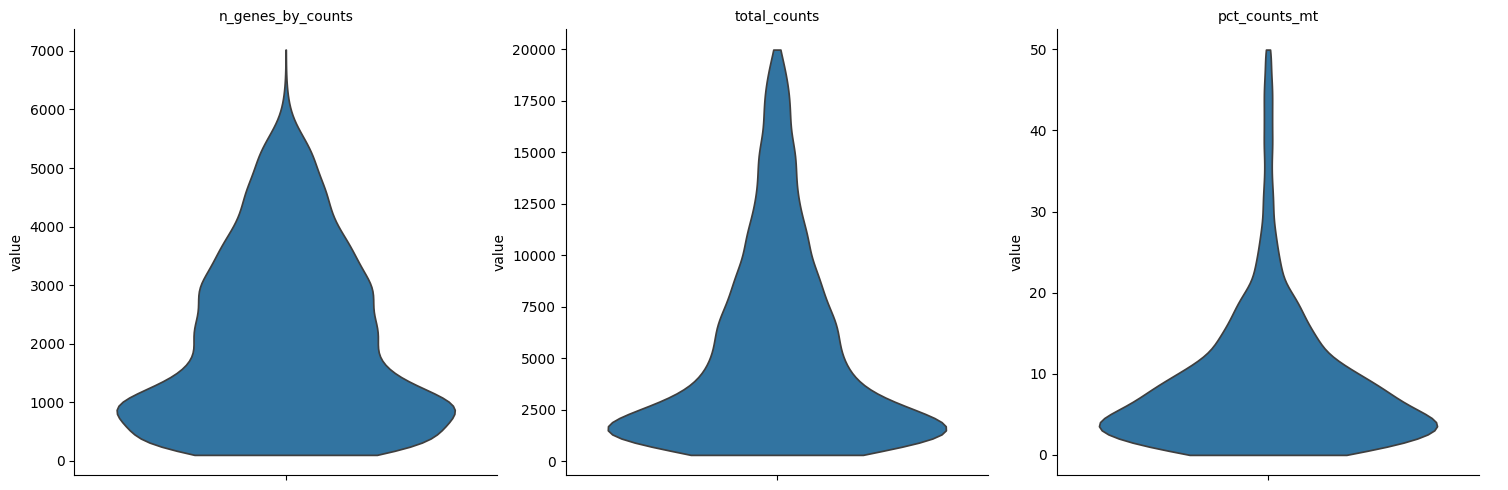

In [32]:
result.data.private

In [33]:
result.approve()

✅ Approving result for: make_violin_result
   Sending to: client2
🔒 Using PRIVATE data from Twin 'make_violin_result...'
✓ Result sent to client2's inbox
💡 They can load it with: bv.inbox()['make_violin_result'].load()


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📤 Send Result
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📧 Envelope ID: fb462ca088ca4053...
📝 Name: make_violin_result
👤 Sender: client1 → Recipient: client2
📁 File: shared/client2/fb462ca088ca4053b356cd622c35239f.beaver
📦 Type: Twin (data)

✅ Successfully sent to client2's inbox
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [34]:
bv.wait_for_message()

📬 New message: request_show_embedding_for_embedding_plot
   From: client2


(BeaverEnvelope [CODE]: request_show_embedding_for_embedding_plot
   From: client2
   Type: ComputationRequest (__main__)
   Size: 45935147 bytes
   Created: 2025-11-25 05:11:08 UTC
   ID: 4c897075...
 
 Arguments (1):
   [0] 🌍 PUBLIC Twin: patient_sc (type: Twin[dict], owner: client1)
 
 Bound Data:
   │ 🌍 PUBLIC
   │   Parameter: patient_sc
   │   Type: dict
   │   Owner: client1
   │   📊 Mock data available for testing
 
 Signature: request_show_embedding_for_embedding_plot(adata)
 
 Source:
   def show_embedding(adata):
       n_cells = adata.n_obs
       print("stdout", "n_cells", adata.n_obs)
       import sys
       sys.stdout.write("Another stdout line\n")
       sys.stderr.write("Another stderr line\n")
   
       fig = sc.pl.embedding(
           patient_sc.public,
           basis='X_umap',
           color=['pct_counts_mt','cell_type'],
           ncols=1,size=15,
           frameon=False, 
           show=False
       )
       return fig,
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [35]:
bv.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
request_make_violin_for_result,83adf818b84c...,client2,ComputationRequest,45935116,2025-11-25 05:11:03,
request_show_embedding_for_embedding_plot,4c897075d45a...,client2,ComputationRequest,45935147,2025-11-25 05:11:08,


In [36]:
bv.inbox()[1].load()

✓ Loaded 'request_show_embedding_for_embedding_plot' into globals


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: show_embedding_result
   Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: show_embedding

📦 Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=9a31fab0e0d5... result=7840a2b3ea7a...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [37]:
embedding_result = request_show_embedding_for_embedding_plot.run_both()

🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
✓ Mock result: list
🔒 Step 2/2: Executing on real/private data...
✓ Private result: list


In [38]:
embedding_result.data.private

[<Axes: title={'center': 'pct_counts_mt'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_umap1', ylabel='X_umap2'>]

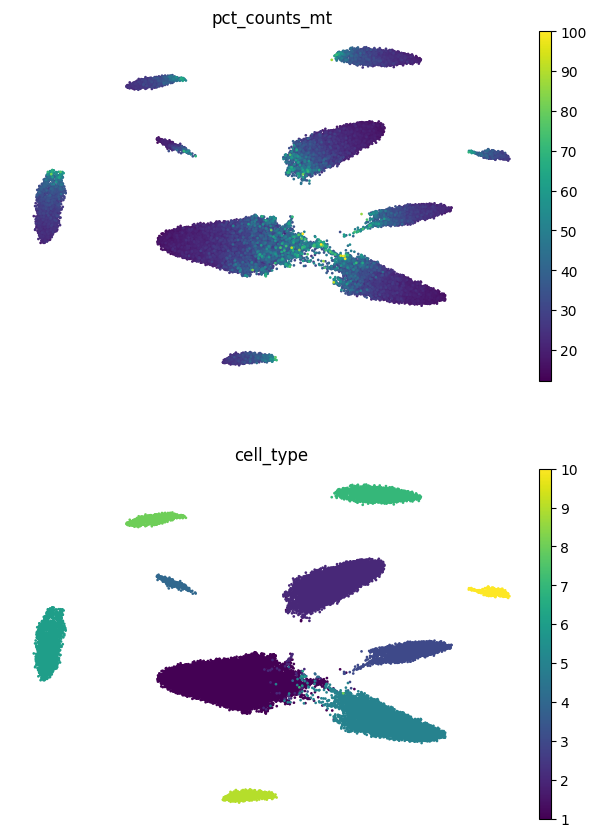

In [39]:
embedding_result.private_figures[0]

In [40]:
embedding_result.approve()

✅ Approving result for: show_embedding_result
   Sending to: client2
🔒 Using PRIVATE data from Twin 'show_embedding_result...'
✓ Result sent to client2's inbox
💡 They can load it with: bv.inbox()['show_embedding_result'].load()


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📤 Send Result
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📧 Envelope ID: 9c2b5a5a49e049e8...
📝 Name: show_embedding_result
👤 Sender: client1 → Recipient: client2
📁 File: shared/client2/9c2b5a5a49e049e8ba35766cd5571954.beaver
📦 Type: Twin (data)

✅ Successfully sent to client2's inbox
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [41]:
bv.wait_for_message()

📬 New message: request_plot_pca_variance_for_pca_variance
   From: client2


(BeaverEnvelope [CODE]: request_plot_pca_variance_for_pca_variance
   From: client2
   Type: ComputationRequest (__main__)
   Size: 46043478 bytes
   Created: 2025-11-25 05:12:08 UTC
   ID: 0128d86b...
 
 Arguments (1):
   [0] 🌍 PUBLIC Twin: patient_sc (type: Twin[dict], owner: client1)
 
 Bound Data:
   │ 🌍 PUBLIC
   │   Parameter: patient_sc
   │   Type: dict
   │   Owner: client1
   │   📊 Mock data available for testing
 
 Signature: request_plot_pca_variance_for_pca_variance(adata)
 
 Source:
   def plot_pca_variance(adata):
       adata.layers['raw_counts'] = adata.X.copy()
       sc.pp.normalize_total(adata, target_sum=1e4)
       sc.pp.log1p(adata)
       sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='raw_counts', n_top_genes=5000)
       sc.pp.pca(adata, use_highly_variable=True)
       with plt.rc_context({'figure.figsize':(4,3)}):
           sc.pl.pca_variance_ratio(adata, n_pcs=50),
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ⚡ Act

In [42]:
bv.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
request_make_violin_for_result,83adf818b84c...,client2,ComputationRequest,45935116,2025-11-25 05:11:03,
request_show_embedding_for_embedding_plot,4c897075d45a...,client2,ComputationRequest,45935147,2025-11-25 05:11:08,
request_plot_pca_variance_for_pca_variance,0128d86b72ea...,client2,ComputationRequest,46043478,2025-11-25 05:12:08,


In [43]:
bv.inbox()[2]

BeaverEnvelope [CODE]: request_plot_pca_variance_for_pca_variance
  From: client2
  Type: ComputationRequest (__main__)
  Size: 46043478 bytes
  Created: 2025-11-25 05:12:08 UTC
  ID: 0128d86b...

Arguments (1):
  [0] 🌍 PUBLIC Twin: patient_sc (type: Twin[dict], owner: client1)

Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

Signature: request_plot_pca_variance_for_pca_variance(adata)

Source:
  def plot_pca_variance(adata):
      adata.layers['raw_counts'] = adata.X.copy()
      sc.pp.normalize_total(adata, target_sum=1e4)
      sc.pp.log1p(adata)
      sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='raw_counts', n_top_genes=5000)
      sc.pp.pca(adata, use_highly_variable=True)
      with plt.rc_context({'figure.figsize':(4,3)}):
          sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [44]:
bv.inbox()[2].load()

✓ Loaded 'request_plot_pca_variance_for_pca_variance' into globals


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: plot_pca_variance_result
   Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: plot_pca_variance

📦 Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=ec57f4547f29... result=e7bc3e72ea1b...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [45]:
request_plot_pca_variance_for_pca_variance

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: plot_pca_variance_result
   Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: plot_pca_variance

📦 Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=ec57f4547f29... result=e7bc3e72ea1b...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [46]:
pca_result = request_plot_pca_variance_for_pca_variance.run_both()

🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
✓ Mock result: NoneType
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType


In [47]:
pca_result

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ComputationResult: plot_pca_variance_result
  Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  Twin: plot_pca_variance_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    {'_none_result': True, 'has_figures': True}    ← .value uses this
  🌍 Public    {'_none_result': True, 'has_figures': True}    ✓
  Live: ⚫ Disabled
  ⚠️  Captured stderr: 698 chars
  📊 Captured figures: 2
  IDs: twin=a981254a... private=bb5d254d... public=d0611382...
  💡 Access: .public_stdout, .public_stderr, .public_figures

  💡 Actions:
     .approve()           - Send private/real result back
     .approve_mock()      - Send mock result (continue iteration)
     .reject(message)     - Reject with explanation
     .data                - Access Twin to inspect/modify

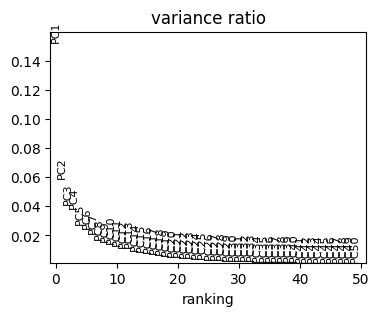

In [48]:
pca_result.private_figures[0]

In [49]:
pca_result.approve()

✅ Approving result for: plot_pca_variance_result
   Sending to: client2
🔒 Using PRIVATE data from Twin 'plot_pca_variance_result...'
✓ Result sent to client2's inbox
💡 They can load it with: bv.inbox()['plot_pca_variance_result'].load()


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📤 Send Result
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📧 Envelope ID: 5c15ce37f96749e8...
📝 Name: plot_pca_variance_result
👤 Sender: client1 → Recipient: client2
📁 File: shared/client2/5c15ce37f96749e8bbb37f0dcc752830.beaver
📦 Type: Twin (data)

✅ Successfully sent to client2's inbox
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [50]:
bv.wait_for_message()

📬 New message: request_umap_embedding_for_umap_embeddings
   From: client2


(BeaverEnvelope [CODE]: request_umap_embedding_for_umap_embeddings
   From: client2
   Type: ComputationRequest (__main__)
   Size: 46043017 bytes
   Created: 2025-11-25 05:12:56 UTC
   ID: dffb0f64...
 
 Arguments (1):
   [0] 🌍 PUBLIC Twin: patient_sc (type: Twin[dict], owner: client1)
 
 Bound Data:
   │ 🌍 PUBLIC
   │   Parameter: patient_sc
   │   Type: dict
   │   Owner: client1
   │   📊 Mock data available for testing
 
 Signature: request_umap_embedding_for_umap_embeddings(adata)
 
 Source:
   def umap_embedding(adata):
       sc.pp.neighbors(adata, n_pcs=50)
       sc.tl.umap(adata)
       return sc.pl.embedding(
           adata,
           basis='X_umap',
           color=['cell_type'],
           ncols=1,size=15,
           frameon=False, 
           show=True
       ),
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ⚡ Action: umap_embedding_result
    Request from: client2
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 
 📋 F

In [51]:
bv.inbox()

name,id,sender,type,size_bytes,created_at,reply_to
request_make_violin_for_result,83adf818b84c...,client2,ComputationRequest,45935116,2025-11-25 05:11:03,
request_show_embedding_for_embedding_plot,4c897075d45a...,client2,ComputationRequest,45935147,2025-11-25 05:11:08,
request_plot_pca_variance_for_pca_variance,0128d86b72ea...,client2,ComputationRequest,46043478,2025-11-25 05:12:08,
request_umap_embedding_for_umap_embeddings,dffb0f643ba6...,client2,ComputationRequest,46043017,2025-11-25 05:12:56,


In [52]:
bv.inbox()[3]

BeaverEnvelope [CODE]: request_umap_embedding_for_umap_embeddings
  From: client2
  Type: ComputationRequest (__main__)
  Size: 46043017 bytes
  Created: 2025-11-25 05:12:56 UTC
  ID: dffb0f64...

Arguments (1):
  [0] 🌍 PUBLIC Twin: patient_sc (type: Twin[dict], owner: client1)

Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

Signature: request_umap_embedding_for_umap_embeddings(adata)

Source:
  def umap_embedding(adata):
      sc.pp.neighbors(adata, n_pcs=50)
      sc.tl.umap(adata)
      return sc.pl.embedding(
          adata,
          basis='X_umap',
          color=['cell_type'],
          ncols=1,size=15,
          frameon=False, 
          show=True
      )

In [53]:
bv.inbox()[3].load()

✓ Loaded 'request_umap_embedding_for_umap_embeddings' into globals


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: umap_embedding_result
   Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: umap_embedding

📦 Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=2673586a0827... result=33d7e6aa7fdc...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [54]:
request_umap_embedding_for_umap_embeddings

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: umap_embedding_result
   Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: umap_embedding

📦 Bound Data:
  │ 🌍 PUBLIC
  │   Parameter: patient_sc
  │   Type: dict
  │   Owner: client1
  │   📊 Mock data available for testing

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=2673586a0827... result=33d7e6aa7fdc...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [55]:
umap_result = request_umap_embedding_for_umap_embeddings.run_both()

🧪 Step 1/2: Testing on mock/public data...
🧪 Testing on mock/public data...
✓ Mock result: NoneType
🔒 Step 2/2: Executing on real/private data...
✓ Private result: NoneType


In [56]:
umap_result

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
ComputationResult: umap_embedding_result
  Request from: client2
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠️  Twin: umap_embedding_result (REAL + MOCK DATA)
  ⚠️  Be careful: This Twin contains both real and mock data
  🔒 Private    {'_none_result': True, 'has_figures': True}    ← .value uses this
  🌍 Public    {'_none_result': True, 'has_figures': True}    ✓
  Live: ⚫ Disabled
  📊 Captured figures: 2
  IDs: twin=8b5517c4... private=b1f0c5cf... public=3cc3e7fb...
  💡 Access: .public_stdout, .public_stderr, .public_figures

  💡 Actions:
     .approve()           - Send private/real result back
     .approve_mock()      - Send mock result (continue iteration)
     .reject(message)     - Reject with explanation
     .data                - Access Twin to inspect/modify

In [57]:
umap_result.data.private

{'_none_result': True, 'has_figures': True}

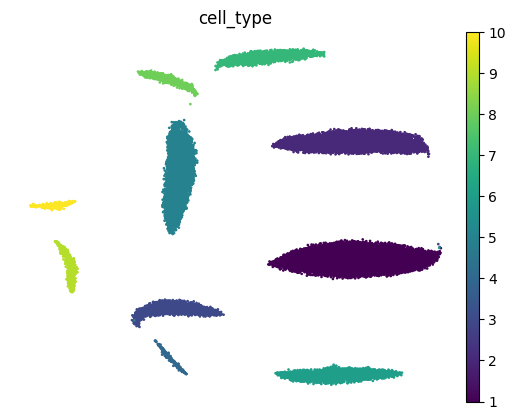

In [58]:
umap_result.public_figures[0]

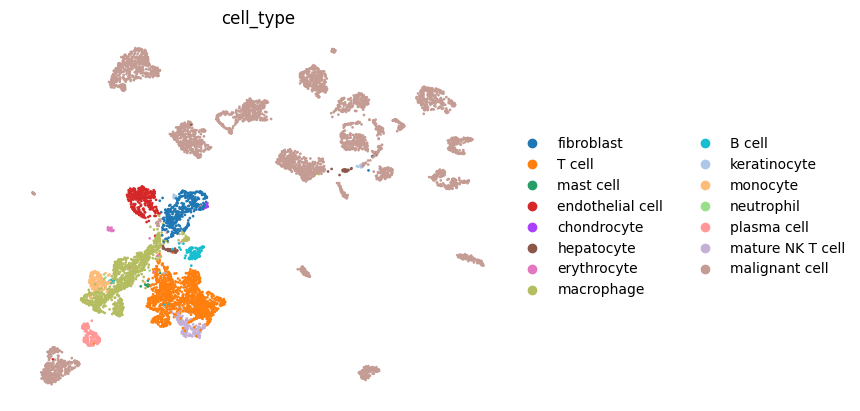

In [59]:
umap_result.private_figures[0]

In [60]:
umap_result.approve()

✅ Approving result for: umap_embedding_result
   Sending to: client2
🔒 Using PRIVATE data from Twin 'umap_embedding_result...'
✓ Result sent to client2's inbox
💡 They can load it with: bv.inbox()['umap_embedding_result'].load()


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📤 Send Result
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📧 Envelope ID: e48bdf0f4d374c22...
📝 Name: umap_embedding_result
👤 Sender: client1 → Recipient: client2
📁 File: shared/client2/e48bdf0f4d374c22b8fe0234f7a395e2.beaver
📦 Type: Twin (data)

✅ Successfully sent to client2's inbox
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━